In [4]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Importing dataset:

In [2]:
MMSI636092331 = pd.read_csv(r"MMSI636092331.csv")
MMSI636092331

,mmsi,lat,long,sog,rot,cog,datetimestamp
0,636092331,-4.767917,48.766190,12.2,15,61.0,2016-03-03 10:58:24
1,636092331,-4.835128,48.742413,13.1,-27,68.5,2016-03-03 10:43:54
2,636092331,-4.835327,48.742360,12.8,-29,68.3,2016-03-03 10:43:53
3,636092331,-4.835595,48.742290,12.4,-37,67.1,2016-03-03 10:43:48
4,636092331,-4.836520,48.742012,12.8,-19,61.4,2016-03-03 10:43:38
...,...,...,...,...,...,...,...
6245,636092331,-5.127655,48.122654,13.3,28,76.4,2016-03-02 04:53:52
6246,636092331,-5.128298,48.122547,13.1,36,74.6,2016-03-02 04:53:46
6247,636092331,-5.128785,48.122480,13.6,-14,71.4,2016-03-02 04:53:40
6248,636092331,-5.129277,48.122353,13.8,34,72.9,2016-03-02 04:53:34


# Converting types:

In [30]:
pd_data = copy.deepcopy(MMSI636092331.sort('datetimestamp'))

pd.to_datetime(pd_data.iloc[:,6]) - pd.to_datetime('2016-03-03 10:58:24')

AttributeError: 'DataFrame' object has no attribute 'sort'

In [92]:
MMSI636092331['datetimestamp'] = pd.to_datetime(MMSI636092331['datetimestamp'])
#MMSI636092331.sort('datetimestamp')
df_sorted = copy.deepcopy(MMSI636092331.sort_values(by = 'datetimestamp', ascending = True ))


myresult = df_sorted['datetimestamp'] -pd.to_datetime('2016-03-02 03:33:34')
myresult.dt.total_seconds()

print(df_sorted.iloc[0,6])

df_sorted['datetimestamp'] = pd.DataFrame(myresult.dt.total_seconds())
#print(df_sorted.head())

df_sorted.iloc[0,6]

2016-03-02 03:33:34


0.0

In [108]:
def convert_dataset(data_in):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    first_obs_date = df_sorted.iloc[0,6]
    
    #Calculating the time difference in seconds
    time_from_zero_sec = (df_sorted['datetimestamp'] -pd.to_datetime(first_obs_date)).dt.total_seconds()
    df_sorted['datetimestamp'] = pd.DataFrame(time_from_zero_sec)

    #Conversion of Course over ground
    
    
    return df_sorted
    
    
    

In [ ]:
def convert_cog(data_in):
    

In [107]:
convert_dataset(MMSI636092331)

,mmsi,lat,long,sog,rot,cog,datetimestamp
1373,636092331,-5.540490,47.998146,13.6,-8,65.7,0.0
686,636092331,-5.540490,47.998146,13.6,-8,65.7,0.0
1372,636092331,-5.463012,48.021954,13.9,23,66.6,911.0
685,636092331,-5.463012,48.021954,13.9,23,66.6,911.0
1371,636092331,-5.410512,48.037872,13.8,11,64.0,1515.0
...,...,...,...,...,...,...,...
2,636092331,-4.835327,48.742360,12.8,-29,68.3,112219.0
1,636092331,-4.835128,48.742413,13.1,-27,68.5,112220.0
688,636092331,-4.835128,48.742413,13.1,-27,68.5,112220.0
687,636092331,-4.767917,48.766190,12.2,15,61.0,113090.0


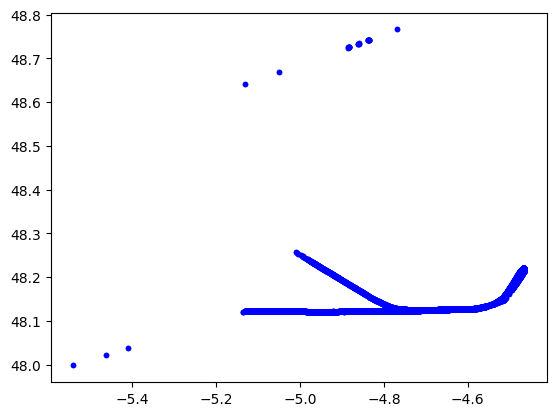

In [3]:
lat = MMSI636092331.iloc[:,1]
long = MMSI636092331.iloc[:,2]

plt.plot(lat,long, "b.")
plt.show()